In [40]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [41]:
df = pd.read_csv("lection1_materials/support_data.csv").drop("Unnamed: 0", 1)
df.head(3)

,Title,Resolution,class,category
0,Need Ethernet access,Please connect the LAN cable to the red port o...,41,1
1,Create new account and share the username and ...,"Go to URL : accountsetup.com, Enter personal d...",35,0
2,FW: Myspace Login Issue-- Ania,"Go to URL : password.reset.com, Enter you logi...",36,0


In [42]:
df['category'].value_counts()

0    125
1     25
Name: category, dtype: int64

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df, df['category'], random_state=0)

In [44]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.column]

pipeline = Pipeline([('title_selector', FeatureSelector(column='Title')), 
                     ('title_tfidf', TfidfVectorizer()), 
                     ('clf', LogisticRegression())])


In [45]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('title_selector', FeatureSelector(column='Title')),
                ('title_tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression())])

In [46]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.08918988, 0.07568621, 0.23507727, 0.16353486, 0.23125079,
       0.08734735, 0.0901742 , 0.08453511, 0.28304286, 0.09788745])

In [47]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix, roc_curve

In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [49]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best threshold=%f, F-score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                       fscore[ix],
                                                                       precision[ix],
                                                                       recall[ix]))

Best threshold=0.214648, F-score=0.960, Precision=0.923, Recall=1.000


In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[25  1]
 [ 2 10]]


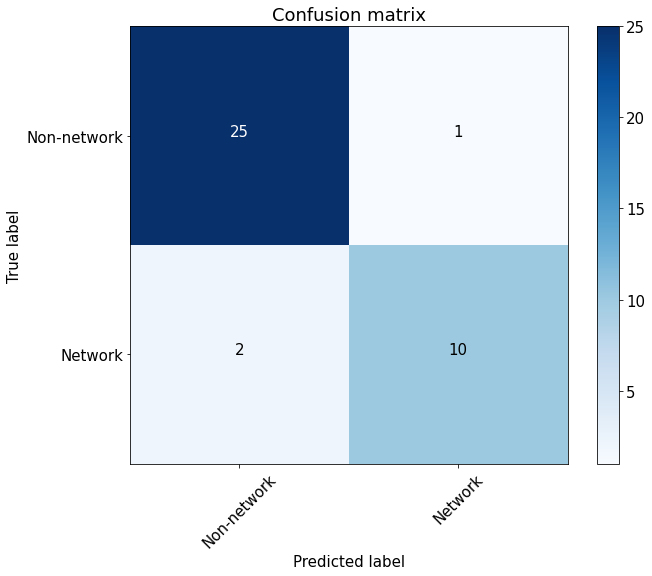

In [51]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-network', 'Network'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()